# Tutorial 1: Neural Nets and Datasets
In this first tutorial, we'll cover the basics of training neural networks and loading/generating datasets. We've extended pytorch neural networks to have a bunch of handy tools. We'll need all these tools to evaluate Lipschitz constants. Since we frequently operate with neural networks trained on real or synthetic datasets, with or without regularization, we cover some tools help us with these tasks.

This Jupyter notebook is intended to be hosted by a server running in the main `LipMIP/` folder (so the imports play nice).


In [11]:
# Step 1: Import things
import sys 
sys.path.append('..')
import torch 

import utilities as utils
from relu_nets import ReLUNet 
import neural_nets.data_loaders as data_loaders
import neural_nets.train as train
import neural_nets.adv_attacks as adv_attacks

## 1: Building a neural net
We only consider neural networks composed of compositions of affine and ReLU layers. We develop a particular type of pytorch `nn.Module` to encapsulate these networks only. These are initialized randomly and defined a priori based only on the size of each layer.


In [12]:
network_A = ReLUNet([4,8,16,2], bias=True) # defines a network R^4->R^2 with fully connected layers with biases
x = torch.rand((10, 4)) # 10 example inputs to network_A
y = network_A(x) # we directly feed inputs to network_A 
print("Input: ", x)
print("Output:", y)

Input:  tensor([[0.1559, 0.0302, 0.6131, 0.0998],
        [0.5606, 0.5102, 0.3566, 0.4731],
        [0.6748, 0.0851, 0.6050, 0.7904],
        [0.5553, 0.5542, 0.9121, 0.1309],
        [0.9032, 0.0735, 0.4890, 0.7229],
        [0.0236, 0.5521, 0.2023, 0.1035],
        [0.0275, 0.1233, 0.5706, 0.9241],
        [0.2221, 0.1325, 0.3143, 0.0304],
        [0.8704, 0.9953, 0.1329, 0.5800],
        [0.0445, 0.1323, 0.1675, 0.5536]])
Output: tensor([[ 0.3602, -0.1227],
        [ 0.3181, -0.1991],
        [ 0.3820, -0.1687],
        [ 0.4342, -0.0649],
        [ 0.3887, -0.1689],
        [ 0.2890, -0.1432],
        [ 0.3096, -0.2180],
        [ 0.3129, -0.1523],
        [ 0.3093, -0.2111],
        [ 0.2767, -0.2126]], grad_fn=<AddmmBackward>)


In [13]:
# We can also recover the inputs to each ReLU unit as such 
preacts = network_A(x, return_preacts=True)
print(len(preacts)) # i'th element is the input to the i'th relu (starting from 0)
assert torch.all(y == preacts[-1]) # final element of preacts is the output of network_A(x)
print([_.shape for _ in preacts])

3
[torch.Size([10, 8]), torch.Size([10, 16]), torch.Size([10, 2])]


## 2: Loading or generating a dataset 
Here we describe how to load the MNIST dataset, as well as the medley of synthetic datasets we use.

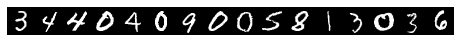

In [14]:
# The standard MNIST dataset can be loaded as
mnist_train = data_loaders.load_mnist_data('train', batch_size=16, shuffle=True) # Training data
mnist_val = data_loaders.load_mnist_data('val', batch_size=16, shuffle=True) # Validation data 

# We can collect and display MNIST images as such
mnist_batch = next(iter(mnist_val))[0] 
utils.display_images(mnist_batch)

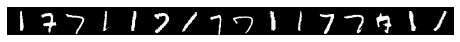

In [15]:
# To select only a subset of the MNIST digits,
mnist17_train = data_loaders.load_mnist_data('train', digits=[1,7], batch_size=16, shuffle=True) # Training data
mnist17_val = data_loaders.load_mnist_data('val', digits=[1,7], batch_size=16, shuffle=True) # Validation data 

mnist17_batch = next(iter(mnist17_val))[0] 
utils.display_images(mnist17_batch)

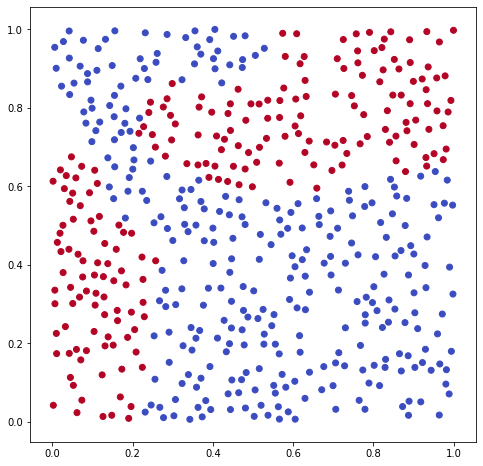

In [16]:
'''
We define several synthetic datasets. Primarily, we use one we'll call a Random K-Cluster
This defines a collection of points over [0,1]^d where each has a label 1...C 
Parameters are the :
    - num_points: number of elements in the dataset (training AND validation)
    - dimension: specifies the d, where the points reside in [0,1]^d
    - num_classes: number of distinct labels 
    - radius: how far each point (in l2 norm) must be from the other points 
    - k: number of 'leaders' we select 
    
The data generation works by randomly sampling num_points points from [0,1]^d,
such that they are all sufficiently separated. Then we randomly select k points to be 'leaders', 
and uniformly randomly assign each 'leader' a label. Then we assign every other point the label 
of their closest 'leader'.
'''

# Parameters of datasets are controlled with the RandomKParameters object 
data_params = data_loaders.RandomKParameters(num_points=512, dimension=2, num_classes=2, k=10, radius=0.01)

# RandomDataset objects represent actual instantiations of a random dataset defined by the params above
random_dataset = data_loaders.RandomDataset(data_params, random_seed=1234)

random_train, random_val = random_dataset.split_train_val(0.75) # split data into training(75%) and val(25%) sets

# If 2-dimensional, we can visualize the dataset as such
random_dataset.plot_2d()

## 3: Training neural nets
With neural nets and datasets defined, we can perform training

In [17]:
network_B = ReLUNet([2, 16, 16, 16, 2]) # make a new net to classify the random_dataset defined above

# Parameters regarding how training are performed are contained within the TrainParameters object 
# By default, we use CrossEntropyLoss and the Adam optimizer with lr=0.001, and test after every epoch

vanilla_train_params = train.TrainParameters(random_train, random_val, 500, # train for 500 epochs
                                             test_after_epoch=100) # test after every 100 epochs

train.training_loop(network_B, vanilla_train_params)

Epoch 00 | Accuracy: 39.06
Epoch 100 | Accuracy: 78.91
Epoch 200 | Accuracy: 97.66
Epoch 300 | Accuracy: 98.44
Epoch 400 | Accuracy: 97.66
Epoch 500 | Accuracy: 97.66


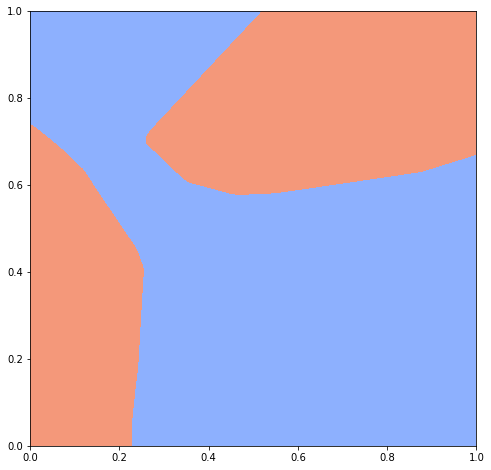

In [8]:
# We can visualize the decision boundaries learned for networks with 2d inputs
network_B.display_decision_bounds((0.0, 1.0), (0.0, 1.0), 100)


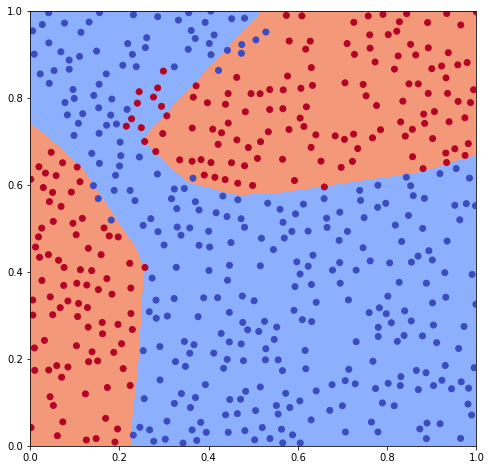

In [9]:
# And we can overlay the dataset on top of this
ax = network_B.display_decision_bounds((0.0, 1.0), (0.0, 1.0), 100)
random_dataset.plot_2d(ax=ax)

## 4: Training With Regularization
We can incorporate custom regularizers into our training loop defined above. As an example, we'll apply standard Tikhonov (l2) regularization to the training of an MNIST network. We will also apply FGSM regularization against an $\ell_\infty$-bounded adversary.

In [10]:
# Training with l2-regularization
network_MNIST = ReLUNet([784, 32, 32, 10]) # simple MNIST network 

# Reload the MNIST datasets
mnist_train = data_loaders.load_mnist_data('train', batch_size=128, shuffle=True) # Training data
mnist_val = data_loaders.load_mnist_data('val', batch_size=128, shuffle=True) # Validation data 

# Build the components of the loss function
cross_entropy_loss = train.XEntropyReg(scalar=1.0)
l2_loss = train.LpWeightReg(lp='l2', scalar=0.01) 

# Build the loss function to use 
loss_functional = train.LossFunctional(regularizers=[cross_entropy_loss, l2_loss])
loss_functional.attach_network(network_MNIST)

# Train the network 
mnist_train_params = train.TrainParameters(mnist_train, mnist_val, 10, loss_functional=loss_functional)
train.training_loop(network_MNIST, mnist_train_params)

# This can be sped up with the 'use_cuda=True' kwarg in training_loop(...)

Epoch 00 | Accuracy: 91.52
Epoch 01 | Accuracy: 93.56
Epoch 02 | Accuracy: 94.15
Epoch 03 | Accuracy: 94.86
Epoch 04 | Accuracy: 95.24
Epoch 05 | Accuracy: 95.53
Epoch 06 | Accuracy: 95.69
Epoch 07 | Accuracy: 95.82
Epoch 08 | Accuracy: 96.43
Epoch 09 | Accuracy: 96.52
Epoch 10 | Accuracy: 96.74


In [ ]:
# Training with FGSM Regularizers 
network_MNIST.re_init_weights() # reset the weights to random 

# Build the FGSM loss 
fgsm_loss = train.LossFunctional(regularizers=[train.FGSM(0.1)]) #FGSM with adversary with 0.1 L_inf bound
fgsm_loss.attach_network(network_MNIST)

# Train the network 
mnist_train_params = train.TrainParameters(mnist_train, mnist_val, 10, loss_functional=loss_functional)
train.training_loop(network_MNIST, mnist_train_params)

In [ ]:
# Evaluate the adversarially trained network
import neural_nets.adv_attacks as adv_attacks
adversary = adv_attacks.build_attack_partial(adv_attacks.fgsm,linf_bound=0.1)
adv_attacks.eval_dataset(network_MNIST, mnist_val, adversary)